In [23]:
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy import UTCDateTime


In [2]:

pn_model = sbm.PhaseNet.from_pretrained("stead")

In [3]:
seisbench.use_backup_repository()
eq_model = sbm.EQTransformer.from_pretrained("stead")

2024-09-10 18:11:29,531 | seisbench | WARNING | Setting remote root to: https://seisbench.gfz-potsdam.de/mirror/
Please note that this can affect your download speed.


In [4]:
data = sbd.TXED(cache="full",sampling_rate=100) #Esta accion es recomendable hacerla en terminal pues tarda mucho
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-09-10 18:11:30,554 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
Preloading waveforms:   0%|          | 0/1046 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 1046/1046 [00:20<00:00, 50.33it/s]


TXED - 1046 traces


In [5]:
data.metadata.columns

Index(['index', 'trace_coda_end_sample', 'source_depth_km',
       'source_latitude_deg', 'source_longitude_deg', 'source_magnitude',
       'source_origin_time', 'trace_p_arrival_sample', 'trace_p_arrival_time',
       'trace_p_arrival_uncertainty_s', 'trace_s_arrival_sample',
       'trace_s_arrival_time', 'trace_s_arrival_uncertainty_s', 'trace_snr_db',
       'station_elevation_m', 'station_latitude_deg', 'station_longitude_deg',
       'station_code', 'trace_category', 'trace_name_original', 'split',
       'trace_name', 'trace_causal', 'trace_polarity', 'ID_poligono',
       'trace_chunk', 'trace_sampling_rate_hz', 'trace_component_order'],
      dtype='object')

In [6]:
data.metadata.source_origin_time

0       2019-04-02T03:34:48.725819Z
1       2019-04-02T15:44:47.758892Z
2       2019-04-03T00:19:32.460730Z
3       2019-04-03T02:49:31.391207Z
4       2019-04-03T04:07:27.403390Z
                   ...             
1041    2023-06-14T22:38:46.693381Z
1042    2023-06-19T10:46:39.228074Z
1043    2023-06-19T10:58:23.560929Z
1044    2023-06-23T02:10:06.562611Z
1045    2023-07-04T02:25:39.045752Z
Name: source_origin_time, Length: 1046, dtype: object

In [7]:
data.citation


'Chen, Y., A. Savvaidis, O. M. Saad, G.-C. D. Huang, D. Siervo, V. O’Sullivan, C. McCabe, B. Uku, P. Fleck, G. Burke, N. L. Alvarez, J. Domino, and I. Grigoratos, “TXED: the texas earthquake dataset for AI,” Seismological Research Letters, vol. 1, no. 1, p. doi: 10.1785/0220230327, 2024.'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
pn_model.to(device)
eq_model.to(device)

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0-6): 7 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (res_cnn_stack): ResCNNStack(
    (members): ModuleList(
      (0-3): 4 x ResCNNBlock(
        (dropout): SpatialDropout1d(
          (dropout): Dropout2d(p=0.1, inplace=False)
        )
        (norm1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(

In [9]:
batch_size=128
data_generator = sbg.GenericGenerator(data)
data_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

data_loader = DataLoader(data_generator, batch_size=batch_size, shuffle=False)

In [10]:
pn_model.eval()
P_pn = []
S_pn = []
for batch_id, batch in enumerate(data_loader):
    output = pn_model(batch['X'].float())
    for stream in output:
        P_pn.append(torch.argmax(stream[0]).item())
        S_pn.append(torch.argmax(stream[1]).item())


In [11]:
len(P_pn)

1046

18


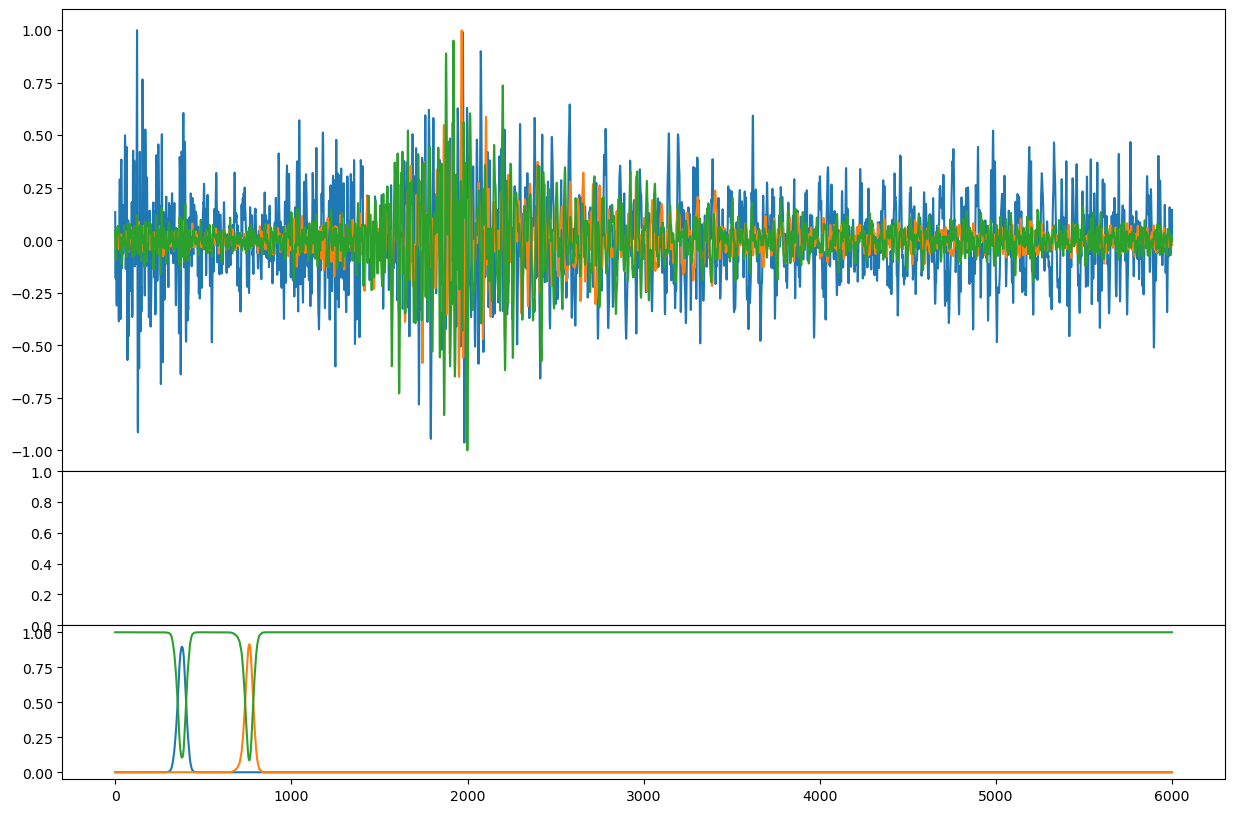

In [12]:
id= np.random.randint(22)
print(id)
sample = data_generator[id]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
#axs[1].plot(sample["y"].T)

pn_model.eval()  # close the model for evaluation
axs[2].plot(output[id].detach().numpy().T)


In [13]:
eq_model.eval()
P_eq = []
S_eq = []
for batch_id, batch in enumerate(data_loader):
    output = eq_model(batch['X'].float())
    output = torch.stack(output, dim=1)
    
    for stream in output:
        P_eq.append(torch.argmax(stream[1]).item())
        S_eq.append(torch.argmax(stream[0]).item())

In [14]:
len(P_eq)

1046

2


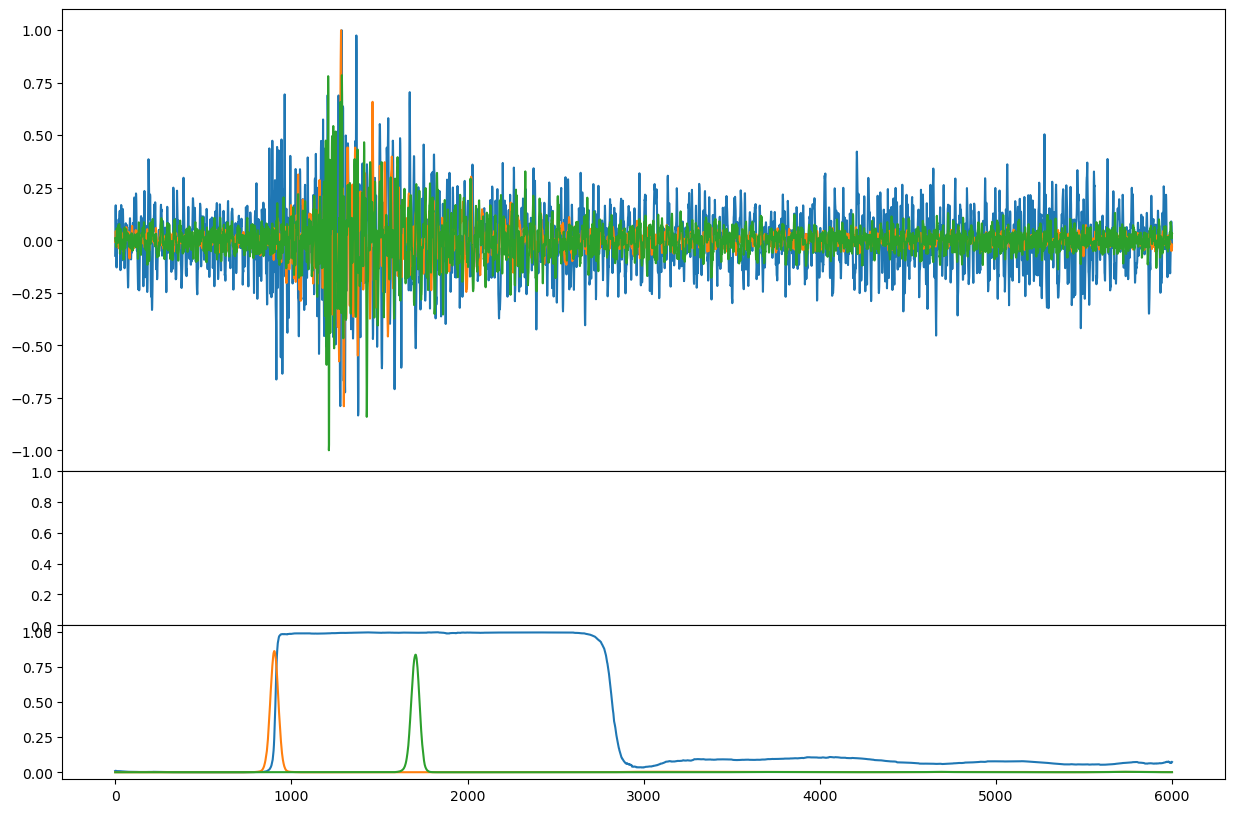

In [15]:
id= np.random.randint(22)
print(id)
sample = data_generator[id]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
#axs[1].plot(sample["y"].T)

pn_model.eval()  # close the model for evaluation
axs[2].plot(output[id].detach().numpy().T)


In [16]:
#P_pn = P_pn.detach().numpy()
data.metadata['P_pn'] = list(P_pn)

#S_pn = S_pn.detach().numpy()
data.metadata['S_pn'] = list(S_pn)

#P_eq = P_eq.detach().numpy()
data.metadata['P_eq'] = list(P_eq)

#S_eq = S_eq.detach().numpy()
data.metadata['S_eq'] = list(S_eq)


data.metadata.head()

,index,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,...,trace_causal,trace_polarity,ID_poligono,trace_chunk,trace_sampling_rate_hz,trace_component_order,P_pn,S_pn,P_eq,S_eq
0,0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,...,unknown,unknown,2,,100,ZNE,1001,1189,1033,1142
1,1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,...,unknown,unknown,1,,100,ZNE,409,439,394,588
2,2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,...,unknown,unknown,2,,100,ZNE,878,1019,861,1181
3,3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,...,unknown,unknown,2,,100,ZNE,959,1296,1051,1242
4,4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,...,unknown,unknown,2,,100,ZNE,375,672,420,617


In [25]:
data.metadata.columns
data.metadata.trace_start_time

0       2019-04-02T03:34:42.281560Z
1       2019-04-02T15:44:45.794274Z
2       2019-04-03T00:19:27.231650Z
3       2019-04-03T02:49:24.867029Z
4       2019-04-03T04:07:27.011541Z
                   ...             
1041    2023-06-14T22:38:43.887105Z
1042    2023-06-19T10:46:40.330857Z
1043    2023-06-19T10:58:26.159443Z
1044    2023-06-23T02:10:08.392403Z
1045    2023-07-04T02:25:35.359003Z
Name: trace_start_time, Length: 1046, dtype: object

In [29]:
sample_rate = 100
data.metadata["trace_start_time"] = data.metadata['trace_p_arrival_time'].apply(lambda x: UTCDateTime(x))-data.metadata['trace_p_arrival_sample']/sample_rate

data.metadata['P_pn_time'] = data.metadata.apply(lambda row: row['trace_start_time'] + row['P_pn'] / sample_rate, axis=1)

data.metadata['S_pn_time'] = data.metadata.apply(lambda row: row['trace_start_time'] + row['S_pn'] / sample_rate, axis=1)

data.metadata['P_eq_time'] = data.metadata.apply(lambda row: row['trace_start_time'] + row['P_eq'] / sample_rate, axis=1)

data.metadata['S_eq_time'] = data.metadata.apply(lambda row: row['trace_start_time'] + row['S_eq'] / sample_rate, axis=1)


In [30]:
data.metadata.head()

,index,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,...,trace_component_order,P_pn,S_pn,P_eq,S_eq,trace_start_time,P_pn_time,S_pn_time,P_eq_time,S_eq_time
0,0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,...,ZNE,1001,1189,1033,1142,2019-04-02T03:34:42.281560Z,2019-04-02T03:34:52.291560Z,2019-04-02T03:34:54.171560Z,2019-04-02T03:34:52.611560Z,2019-04-02T03:34:53.701560Z
1,1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,...,ZNE,409,439,394,588,2019-04-02T15:44:45.794274Z,2019-04-02T15:44:49.884274Z,2019-04-02T15:44:50.184274Z,2019-04-02T15:44:49.734274Z,2019-04-02T15:44:51.674274Z
2,2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,...,ZNE,878,1019,861,1181,2019-04-03T00:19:27.231650Z,2019-04-03T00:19:36.011650Z,2019-04-03T00:19:37.421650Z,2019-04-03T00:19:35.841650Z,2019-04-03T00:19:39.041650Z
3,3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,...,ZNE,959,1296,1051,1242,2019-04-03T02:49:24.867029Z,2019-04-03T02:49:34.457029Z,2019-04-03T02:49:37.827029Z,2019-04-03T02:49:35.377029Z,2019-04-03T02:49:37.287029Z
4,4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,...,ZNE,375,672,420,617,2019-04-03T04:07:27.011541Z,2019-04-03T04:07:30.761541Z,2019-04-03T04:07:33.731541Z,2019-04-03T04:07:31.211541Z,2019-04-03T04:07:33.181541Z


In [ ]:
#para guardar el archivo
#data.metadata.to_csv("/Users/lamb/Documents/Modelo_Velocidades/metadata_Picks.csv",index=False)